In [1]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.generalized_linear_model import GLM
import numpy as np
from scipy.stats import somersd
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import scikitplot as skplt

In [2]:
# Read train and validation data
train = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_t_bin.csv")
val = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_v_bin.csv")

In [3]:
# Implement all changes made to deal with NAs and separation concerns

# Change the data to include a missing category
train['INV'] = train['INV'].fillna('MISSING')
train['CC'] = train['CC'].fillna('MISSING')
train['CCPURC'] = train['CCPURC'].fillna('MISSING')
train['HMOWN'] = train['HMOWN'].fillna('MISSING')

# Since we have quasi-complete separation problems for CASHBK and MMCRED, we combine their categories
train.loc[train['CASHBK'] >= 2, ['CASHBK']] = 1
train.loc[train['MMCRED'] >= 3, ['MMCRED']] = 3

# Remove the MMBAL_Bin variables
train = train.drop(['MMBAL_Bin'], axis = 1)

In [4]:
# Logistic Regression model

# For the variables that had 'Missing' imputed for missing values, change the type to str
train[['INV', 'CC', 'CCPURC', 'HMOWN']] = train[['INV', 'CC', 'CCPURC', 'HMOWN']].astype(str)

# Iterate over columns and replace string values with integers
for column in train.columns:
    if train[column].dtype == 'object':
        train[column] = train[column].str.replace('.0', '', regex = False)

# Convert all predictor variables to categorical data type
predictors = [col for col in train.columns if col != 'INS']
train[predictors] = train[predictors].astype('category')

# Create dummy variables for categorical variables
train_dummy = pd.get_dummies(train.drop(columns=['INS']), drop_first=True)

# Create the formula for the predictor variables
predictors = [column for column in train_dummy.columns if column != 'CCPURC_4']  # Remove dummy variable CCPURC_4 due to separation issues
predictors_formula = ' + '.join([predictor for predictor in predictors])

# Add target variable back into train_dummy
train_dummy['INS'] = train['INS']
del train_dummy['CCPURC_4']  # Remove dummy variable CCPURC_4 due to separation issues

# Final list of predictors
predictors_formula = 'DDA_1 + DIRDEP_1 + NSF_1 + SAV_1 + ATM_1 + IRA_1 + LOC_1 + INV_1 + INV_MISSING + ILS_1 + MM_1 + MMCRED_1 + MTG_1 + CC_1 + CCPURC_1 + CCPURC_MISSING + BRANCH_B12 + BRANCH_B14 + BRANCH_B15 + BRANCH_B16 + BRANCH_B18 + BRANCH_B19 + BRANCH_B2 + RES_U + DDABAL_Bin_3 + DDABAL_Bin_4 + DDABAL_Bin_5 + DDABAL_Bin_6 + DDABAL_Bin_7 + DDABAL_Bin_8 + ACCTAGE_Bin_2 + CHECKS_Bin_4 + NSFAMT_Bin_2 + PHONE_Bin_3 + PHONE_Bin_4 + TELLER_Bin_2 + TELLER_Bin_3 + SAVBAL_Bin_4 + SAVBAL_Bin_5 + SAVBAL_Bin_6 + SAVBAL_Bin_7 + ATMAMT_Bin_3 + POS_Bin_3 + POSAMT_Bin_3 + CDBAL_Bin_2 + CDBAL_Bin_3 + INVBAL_Bin_3 + MTGBAL_Bin_2 + MTGBAL_Bin_3 + CCBAL_Bin_3 + INCOME_Bin_2 + INCOME_Bin_3 + HMVAL_Bin_3 + HMVAL_Bin_4 + HMVAL_Bin_5'

# Main effects only binary logistic regression model
lr_model = GLM.from_formula('INS ~ {}'.format(predictors_formula), data = train_dummy, family = Binomial()).fit()
print("The main effects model's AIC is " + str(lr_model.aic))
lr_model.summary()

The main effects model's AIC is 8778.98361909804


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    INS   No. Observations:                 8495
Model:                            GLM   Df Residuals:                     8445
Model Family:                Binomial   Df Model:                           49
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4339.5
Date:                Tue, 16 Apr 2024   Deviance:                       8679.0
Time:                        10:06:08   Pearson chi2:                 8.45e+03
No. Iterations:                    63   Pseudo R-squ. (CS):             0.2328
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.5601      1.186     -2.159      0.031      -4.884      -0.236
DDA_1             -1.3998      0.136    -10.284      0.000      -1.667      -1.133
DIRDEP_1          -0.1476      0.066     -2.220      0.026      -0.278      -0.017
NSF_1              0.6064      0.169      3.582      0.000       0.275       0.938
SAV_1             -0.4257      0.106     -4.003      0.000      -0.634      -0.217
ATM_1             -0.1171      0.063     -1.851      0.064      -0.241       0.007
IRA_1              0.4801      0.113      4.266      0.000       0.260       0.701
LOC_1             -0.1798      0.112     -1.601      0.109      -0.400       0.040
INV_1              0.7567      0.191      3.958      0.000       0.382       1.131
INV_MISSING       -0.0687      0.018     -3.903      0.000      -0.103      -0.034
ILS_1             -0.4927      0.130     -3.789      0.000      -0.748      -0.238
MM_1               0.8255      0.092      8.977      0.000       0.645       1.006
MMCRED_1          -0.1752      0.156     -1.120      0.263      -0.482       0.131
MTG_1              1.4688      1.290      1.139      0.255      -1.059       3.997
CC_1               0.2991      0.063      4.723      0.000       0.175       0.423
CCPURC_1           0.1377      0.097      1.419      0.156      -0.052       0.328
CCPURC_MISSING    -0.0687      0.018     -3.903      0.000      -0.103      -0.034
BRANCH_B12         0.2608      0.206      1.266      0.205      -0.143       0.664
BRANCH_B14        -0.5875      0.159     -3.699      0.000      -0.899      -0.276
BRANCH_B15        -0.2242      0.123     -1.816      0.069      -0.466       0.018
BRANCH_B16        -0.7363      0.142     -5.168      0.000      -1.016      -0.457
BRANCH_B18         0.3861      0.169      2.283      0.022       0.055       0.717
BRANCH_B19         0.3569      0.222      1.609      0.108      -0.078       0.791
BRANCH_B2         -0.1462      0.080     -1.819      0.069      -0.304       0.011
RES_U             -0.0795      0.055     -1.447      0.148      -0.187       0.028
DDABAL_Bin_3       0.2993      0.145      2.063      0.039       0.015       0.584
DDABAL_Bin_4       0.6013      0.135      4.445      0.000       0.336       0.866
DDABAL_Bin_5       0.8691      0.141      6.156      0.000       0.592       1.146
DDABAL_Bin_6       1.1381      0.137      8.300      0.000       0.869       1.407
DDABAL_Bin_7       1.3959      0.137     10.182      0.000       1.127       1.665
DDABAL_Bin_8       1.9382      0.155     12.504      0.000       1.634       2.242
ACCTAGE_Bin_2     -0.1794      0.121     -1.485      0.138      -0.416       0.057
CHECKS_Bin_4      -0.5514      0.069     -7.982      0.000      -0.687      -0.416
NSFAMT_Bin_2      -0.3476      0.203     -1.714      0.086      -0.745       0.050
PHONE_Bin_3 

# Logistic Regression Model Interpretation

## Training Dataset

In [5]:
# Predicted probabilities of logistic regression model
train_dummy['INS_hat'] = lr_model.predict(train_dummy)
train_dummy[['INS_hat']]

,INS_hat
0,0.266802
1,0.383170
2,0.193319
3,0.056678
4,0.133114
...,...
8490,0.293323
8491,0.159250
8492,0.685649
8493,0.383170


### Probability-based Metrics

* **Concordance**: for a pair of observations with and without the event, the pair is **concordant** if the
one with the event had the higher predicted probability of having the event
* **Discrimination**: the model’s ability to separate the events from the non-events. Specifically, the coefficient of discrimination is the difference in average predicted probability between 1s and 0s

### Classification-based Metrics

* **ROC curve**: visual representation of the model’s false positive rate and true positive rate
* **AUC**: metric that shows how well the model distinguishes between events and non-events
* **K-S statistic**: tests whether there is a difference between two cumulative distribution functions; the actual statistic is the maximum difference between the true positive rate and the false positive rate and **K-S statistic = Youden's index**
* **Accuracy**: given all predictions, the rate at which our model correctly predicts events and non-events. This is equal to the rate of true positives and true negatives
* **Lift**: measures the effectiveness of the model in identifying events compared to making random predictions/selections

### Side Note: In practice, when establishing the optimal cutoff point, always prioritize the business cost and value


In [6]:
# Compute concordance using Somer's D statistic
somers_d = somersd(train_dummy['INS'], train_dummy['INS_hat']).statistic
print(f'Concordance percentage is {(somers_d + 1)/2:.2%}')

# Out of all the possible pairs of actual values of 0 and 1, meaning one observation in which the customer did not purchase the annuity product and one in
# which the customer did, our model ranks the purchaser as having a higher predicted probability than the nonpurchaser 80.21% of the time

Concordance percentage is 80.21%


In [7]:
# Compute coefficient of discrimination
p1 = train_dummy[train_dummy['INS'] == 1]['INS_hat']
p0 = train_dummy[train_dummy['INS'] == 0]['INS_hat']

coef_discrim = p1.mean() - p0.mean()
print('Coefficient of discrimination is', round(coef_discrim, 2))

# The difference between the average predicted probability of customers who purchased the 
# annuity product is 0.25 higher than the average predicted probability of those who did not.

Coefficient of discrimination is 0.25


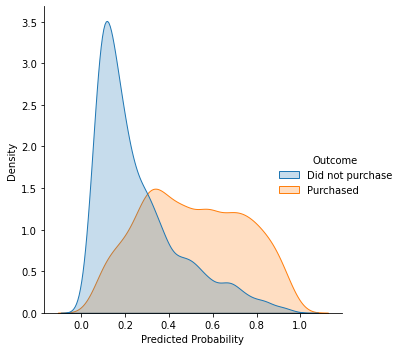

In [8]:
# Visualize the discrimination slope

ax = sns.displot(data = train_dummy, x = train_dummy['INS_hat'], hue = 'INS', common_norm = False, kind = 'kde', fill = True)
ax.set(xlabel = 'Predicted Probability', ylabel = 'Density')
ax._legend.set_title('Outcome')
new_labels = ['Did not purchase', 'Purchased']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)
plt.show()

,TPR,FPR,Cut-off,Youden
1863,0.802605,0.328313,0.288129,0.474292
1836,0.795408,0.321140,0.293329,0.474267
1852,0.799863,0.325623,0.290451,0.474240
1832,0.794380,0.320244,0.293868,0.474136
1835,0.795065,0.320961,0.293538,0.474104


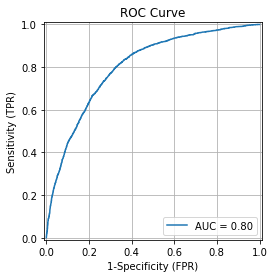

Optimal cutoff is 0.29
Youden's Index (K-S Statistic) is 0.47
Model's AUC is 0.8


In [9]:
# Visualize the ROC curve

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(train_dummy['INS'], train_dummy['INS_hat'])

# Compute Youden's Index
data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr-fpr}
youden = pd.DataFrame(data)
youden = youden.sort_values(by = ['Youden'], ascending = False)
display(youden.head(5))

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc(fpr, tpr))
roc_display.plot()

plt.title('ROC Curve')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.grid(True)

plt.show()

# Print the optimal cutoff, Youden's index, and AUC
print("Optimal cutoff is", round(youden.loc[1863, 'Cut-off'], 2))
print("Youden's Index (K-S Statistic) is", round(youden.loc[1863, 'Youden'], 2))
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))

## Validation Dataset

* Apply all changes made to the training dataset onto the validation dataset
* Get the predicted probabilities of all observations
* Compute and interpret classification metrics

In [10]:
# Change the data to include a missing category
val['INV'] = val['INV'].fillna('MISSING')
val['CC'] = val['CC'].fillna('MISSING')
val['CCPURC'] = val['CCPURC'].fillna('MISSING')
val['HMOWN'] = val['HMOWN'].fillna('MISSING')

In [11]:
# Since we have quasi-complete separation problems for CASHBK and MMCRED, we combine their categories
val.loc[val['CASHBK'] >= 2, ['CASHBK']] = 1
val.loc[val['MMCRED'] >= 3, ['MMCRED']] = 3

In [12]:
# For the variables that had 'Missing' imputed for missing values, change the type to str
val[['INV', 'CC', 'CCPURC', 'HMOWN']] = val[['INV', 'CC', 'CCPURC', 'HMOWN']].astype(str)

# Iterate over columns and replace string values with integers
for column in val.columns:
    if val[column].dtype == 'object':
        val[column] = val[column].str.replace('.0', '', regex = False)

# Convert all predictor variables to categorical data type
predictors_val = [col for col in val.columns if col != 'INS']
val[predictors_val] = val[predictors_val].astype('category')

# Create dummy variables for categorical variables
val_dummy = pd.get_dummies(val.drop(columns=['INS']), drop_first=True)

# Add target variable into dataset
val_dummy['INS'] = val['INS']

In [13]:
# Predicted probabilities of logistic regression model
val_dummy['INS_hat'] = lr_model.predict(val_dummy)
val_dummy[['INS_hat']]


,INS_hat
0,0.593103
1,0.600585
2,0.247363
3,0.340257
4,0.409441
...,...
2119,0.313131
2120,0.836258
2121,0.492979
2122,0.498604


### Confusion Matrix (aka classification table)

In [20]:
val_dummy['INS_pred'] = val_dummy['INS_hat'].map(lambda x: 1 if x > (youden.loc[1863, 'Cut-off']) else 0)
pd.crosstab(val_dummy['INS'], val_dummy['INS_pred'])

INS_pred,0,1
INS,,
0,894,488
1,162,580


### Accuracy

* Measures what percentage of events and non-events were predicted correctly
* The opposite would be the error rate i.e., what percentage of events and non-events were predicted incorrectly
* Note: Accuracy is **NOT** the best when it comes to deciding which mode is best

In [15]:
from sklearn.metrics import accuracy_score

accuracy = np.array([])

for y in range(100):
  val_dummy['INS_pred'] = val_dummy['INS_hat'].map(lambda x: 1 if x > y/100 else 0)
  value_a = accuracy_score(val_dummy['INS'], val_dummy['INS_pred'])
  accuracy = np.append(accuracy, value_a)


data = {'Accuracy': accuracy, 'Cut-off': range(100)}
acc_s = pd.DataFrame(data)

acc_s.sort_values(by = ['Accuracy'], ascending = False)

# The model's accuracy is maximized at 73.54% when the optimal cutoff is defined as 0.48

,Accuracy,Cut-off
48,0.735405,48
42,0.735405,42
41,0.734934,41
47,0.734463,47
46,0.733992,46
...,...,...
4,0.359228,4
3,0.353578,3
2,0.350282,2
1,0.349812,1


### Lift

* Refer to Classification-based metrics above for the definition

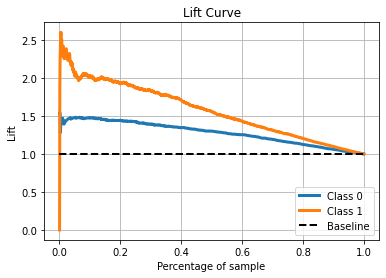

0.34

In [16]:
# Lift Curve
val_dummy['INS_hat0'] = 1 - val_dummy['INS_hat']

skplt.metrics.plot_lift_curve(y_true = val_dummy['INS'], y_probas = val_dummy[['INS_hat0', 'INS_hat']])
plt.show()

# Compute population proportion
train = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_t_bin.csv")
val = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_v_bin.csv")
trainval = pd.concat([train,val])
round(trainval[trainval['INS'] == 1].shape[0]/len(trainval),2)  # Population proportion of customers who buy the annuity product

# The population proportion is approximately 0.34 and correspondingly, we have a lift of around 1.8
# Therefore, if we were to pick the top 34% of customers identified by our model, we would be 1.8 times more 
# likely to find a customer who purchases the annuity product as compared to randomly selecting from the population

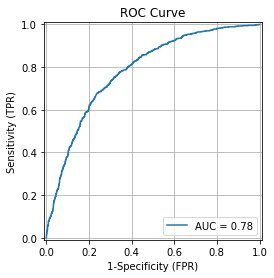

Model's AUC is 0.78


In [17]:
# Visualize the ROC curve

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(val_dummy['INS'], val_dummy['INS_hat'])

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc(fpr, tpr))
roc_display.plot()

plt.title('ROC Curve')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.grid(True)

plt.show()

# Print the AUC
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))

In [37]:
lr_results_train = train_dummy[['INS_hat']]
lr_results_train.to_csv('Train_Results_LR.csv')

lr_results_val = val_dummy[['INS_hat']]
lr_results_val.to_csv('Val_Results_LR.csv')